<div align="center">
    <img src='../../xepimage.png' style='height:100px;'>
</div>


<center><h1 style='font-size:25px'>Model</h1></center>

---

**Autor: Guillermo J. Bergues**

Linear regression for Xepelin project.

Data = scale (third aproach).

In [1]:
! /opt/miniconda3/envs/myenv/bin/pip install --no-cache-dir autogluon -q

In [2]:
import pandas as pd 
import numpy as np

from autogluon.tabular import TabularPredictor, TabularDataset

# Metrics
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv ('../../Data/ds_scale.csv')

In [4]:
df.head()

,amount,amountfinancedByXepelin,PayerId,ReceiverId,days
0,-0.189905,-0.140745,151,19,0
1,-0.193606,-0.140745,126,18,0
2,-0.173390,-0.140745,114,37,7
3,-0.017997,-0.060917,122,12,10
4,-0.189990,-0.140745,55,34,22


<AxesSubplot:>

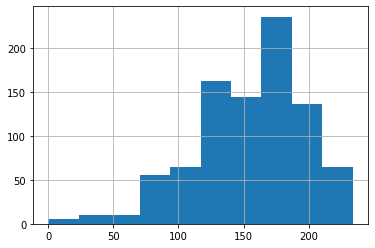

In [5]:
df['days'].hist()

In [6]:
save_path = "agModels"

In [7]:
df_train = df[df["days"] < 180]

In [8]:
label = 'amountfinancedByXepelin'

In [9]:
df_train = TabularDataset(df)

In [10]:
predictor = TabularPredictor(label=label, path=save_path, eval_metric='median_absolute_error').fit(df_train, time_limit=18000)

Beginning AutoGluon training ... Time limit = 18000s
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.4.2
Python Version:     3.8.10
Operating System:   Linux
Train Data Rows:    892
Train Data Columns: 4
Label Column: amountfinancedByXepelin
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (25.436782429666547, -0.1407449106269688, 0.0, 1.00056)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    61781.82 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set f

In [11]:
test_data = df[df["days"] >= 180]

In [12]:
df_test = TabularDataset(test_data)

In [13]:
# values to predict
y_test = df_test[label]  

In [14]:
# delete label column to prove we're not cheating
test_data_nolab = df_test.drop(columns=[label])  

In [15]:
test_data_nolab.head()

,amount,PayerId,ReceiverId,days
628,-0.194870,187,55,182
629,-0.187945,174,82,182
630,-0.192181,145,42,183
631,-0.186257,138,44,183
632,-0.190182,169,38,183


In [16]:
predictor = TabularPredictor.load(save_path)  

In [17]:
y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)

Predictions:  
 628   -0.140745
629   -0.140745
630   -0.140745
631   -0.138557
632   -0.140745
         ...   
887   -0.140745
888   -0.140745
889   -0.108632
890   -0.140745
891   -0.140745
Name: amountfinancedByXepelin, Length: 264, dtype: float32


In [18]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: median_absolute_error on test data: -9.828419189616966e-10
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "median_absolute_error": -9.828419189616966e-10,
    "root_mean_squared_error": -0.07002561129825359,
    "mean_squared_error": -0.004903586237694101,
    "mean_absolute_error": -0.019359172786031976,
    "r2": 0.970048681878183,
    "pearsonr": 0.9897920152931613
}


In [19]:
# Predictions and test data set
df_test_pred = pd.concat([y_test, y_pred], axis=1)
df_test_pred.columns = ['test', 'prediction']
df_test_pred['residual'] = df_test_pred['test'] - df_test_pred['prediction']
df_test_pred.head()

,test,prediction,residual
628,-0.140745,-0.140745,-9.828419e-10
629,-0.140745,-0.140745,-9.828419e-10
630,-0.140745,-0.140745,-9.828419e-10
631,-0.140745,-0.138557,-2.187953e-03
632,-0.140745,-0.140745,-9.828419e-10


Text(0, 0.5, 'Predicted values')

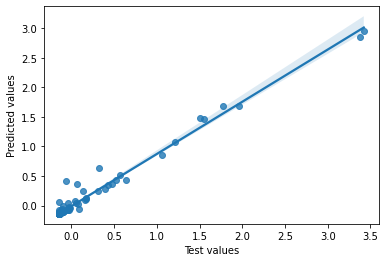

In [20]:
sns.regplot(x=y_test, y=y_pred);
plt.xlabel('Test values')
plt.ylabel('Predicted values')

In [21]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist,-9.828419e-10,-2.989000e-02,0.008790,0.006404,0.004368,0.008790,0.006404,0.004368,1,True,2
1,RandomForestMSE,-9.828419e-10,-9.828419e-10,0.081175,0.069263,0.611168,0.081175,0.069263,0.611168,1,True,5
2,ExtraTreesMSE,-9.828419e-10,-6.014207e-05,0.081259,0.066689,0.577987,0.081259,0.066689,0.577987,1,True,7
3,WeightedEnsemble_L2,-9.828419e-10,-9.828419e-10,0.084606,0.069726,0.916904,0.003431,0.000463,0.305735,2,True,12
4,XGBoost,-4.512593e-04,-7.327805e-04,0.009998,0.006171,0.543510,0.009998,0.006171,0.543510,1,True,9
5,CatBoost,-1.378648e-03,-7.030685e-03,0.005242,0.002257,12.116519,0.005242,0.002257,12.116519,1,True,6
6,NeuralNetTorch,-1.348963e-02,-1.494177e-02,0.034838,0.007960,7.060604,0.034838,0.007960,7.060604,1,True,10
7,KNeighborsUnif,-1.846358e-02,-3.493478e-02,0.008182,0.007789,0.005147,0.008182,0.007789,0.005147,1,True,1
8,NeuralNetFastAI,-3.385419e-02,-3.573063e-02,0.030182,0.009607,1.367458,0.030182,0.009607,1.367458,1,True,8
9,LightGBM,-1.475014e-01,-1.475014e-01,0.003847,0.002346,0.289197,0.003847,0.002346,0.289197,1,True,4


In [22]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.019359172786031976
MSE: 0.004903586237694101
RMSE: 0.07002561129825359


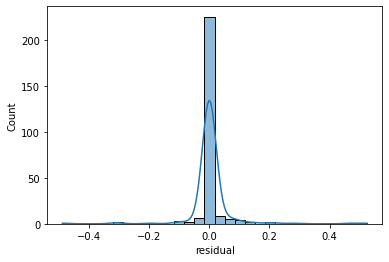

In [23]:
# Distributions of residuals
sns.histplot(data=df_test_pred, x='residual', kde=True, bins=30);

In [24]:
f_importance = predictor.feature_importance(df_test)
f_importance.head()

Computing feature importance via permutation shuffling for 4 features using 264 rows with 5 shuffle sets...
	2.14s	= Expected runtime (0.43s per shuffle set)
	0.67s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
amount,0.000003,0.000006,0.18695,5,0.000014,-0.000009
PayerId,0.000000,0.000000,0.50000,5,0.000000,0.000000
ReceiverId,0.000000,0.000000,0.50000,5,0.000000,0.000000
days,0.000000,0.000000,0.50000,5,0.000000,0.000000
